In [2]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns=None

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from xgboost import XGBClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

In [23]:
data = pd.read_pickle('data_for_modeling.pkl')

In [ ]:
data.head()

In [24]:
data_with_labels = data.iloc[np.where((data.Sale_MF+data.Sale_CC+data.Sale_CL)>0)[0],].copy()

In [25]:
display(data_with_labels.head())
print(data_with_labels.shape)

## 8 CLIENTS ARE MISSING FROM THE SALES DATA WHO HAD POSITIVE SALES...NEED TO CHECK FROM PREVIOUS NOTEBOOK, WHERE THEY WENT.

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
1,850,F,49,44,1,0.0,0.0,0.0,0.0,0.0,43.523214,0.0,0.000000,0.0000,0.000000,0.000000,1392.402857,1392.402857,3,3,1226.345357,1226.345357,0.000000,0.000000,121.928571,6,6,0,0,1,0,1,0,0.0,0.893929,0.000000
4,225,M,14,187,1,0.0,0.0,1.0,0.0,0.0,345.686071,0.0,0.000000,618.3975,0.000000,0.000000,0.007500,0.007500,1,1,130.521429,130.521429,0.000000,111.235714,19.285714,5,5,0,4,1,0,0,1,0.0,0.000000,8.130714
5,827,M,57,50,1,0.0,0.0,1.0,1.0,0.0,49.193571,0.0,0.000000,0.0000,0.464286,0.000000,1755.281786,1750.404286,9,6,1474.321429,1455.035714,607.142857,17.857143,843.250000,26,23,4,1,17,0,1,1,0.0,7.928571,12.242143
6,1231,F,6,232,1,0.0,0.0,0.0,0.0,0.0,819.853929,0.0,0.000000,0.0000,0.000000,0.000000,0.015714,0.015714,2,2,2257.000000,2257.000000,2250.000000,0.000000,0.000000,9,9,6,0,0,0,0,1,0.0,0.000000,24.434643
7,739,M,69,55,1,1.0,8.0,1.0,0.0,1.0,5519.308929,0.0,9824.236786,0.0000,0.000000,3868.679643,208.446786,150.003571,4,2,287.003571,282.575000,0.000000,211.182143,0.000000,7,5,0,3,0,0,1,1,0.0,2.138571,7.785714


(418, 36)


MODEL FOR MUTUAL FUND

# DATA PREPARATION

In [ ]:
print(data_with_labels.Sale_MF.sum() / data_with_labels.shape[0])
print(data_with_labels.Sale_CC.sum() / data_with_labels.shape[0])
print(data_with_labels.Sale_CL.sum() / data_with_labels.shape[0])

In [26]:
# Encode categorical data : Sex
data_encoded = pd.get_dummies(data_with_labels, columns=['Sex'])

In [27]:
data_encoded.head()

,Client,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Sex_F,Sex_M
1,850,49,44,1,0.0,0.0,0.0,0.0,0.0,43.523214,0.0,0.000000,0.0000,0.000000,0.000000,1392.402857,1392.402857,3,3,1226.345357,1226.345357,0.000000,0.000000,121.928571,6,6,0,0,1,0,1,0,0.0,0.893929,0.000000,1,0
4,225,14,187,1,0.0,0.0,1.0,0.0,0.0,345.686071,0.0,0.000000,618.3975,0.000000,0.000000,0.007500,0.007500,1,1,130.521429,130.521429,0.000000,111.235714,19.285714,5,5,0,4,1,0,0,1,0.0,0.000000,8.130714,0,1
5,827,57,50,1,0.0,0.0,1.0,1.0,0.0,49.193571,0.0,0.000000,0.0000,0.464286,0.000000,1755.281786,1750.404286,9,6,1474.321429,1455.035714,607.142857,17.857143,843.250000,26,23,4,1,17,0,1,1,0.0,7.928571,12.242143,0,1
6,1231,6,232,1,0.0,0.0,0.0,0.0,0.0,819.853929,0.0,0.000000,0.0000,0.000000,0.000000,0.015714,0.015714,2,2,2257.000000,2257.000000,2250.000000,0.000000,0.000000,9,9,6,0,0,0,0,1,0.0,0.000000,24.434643,1,0
7,739,69,55,1,1.0,8.0,1.0,0.0,1.0,5519.308929,0.0,9824.236786,0.0000,0.000000,3868.679643,208.446786,150.003571,4,2,287.003571,282.575000,0.000000,211.182143,0.000000,7,5,0,3,0,0,1,1,0.0,2.138571,7.785714,0,1


In [28]:
cols_to_keep_for_training = [ 'Sex_F','Sex_M','Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'Sale_MF' ]
data_train = data_encoded[cols_to_keep_for_training]

## split data into train-test

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data_train[data_train.columns[0:len(data_train.columns)-1]], data_train['Sale_MF'], test_size=0.2, random_state=50, stratify=data_train['Sale_MF'])

In [30]:
print(f"size of training set : {X_train.shape}")
print(f"size of training set : {X_test.shape}")

size of training set : (334, 30)
size of training set : (84, 30)


# Data normalization

In [ ]:
X_train.columns

In [31]:
scaler = StandardScaler()
cols_to_standardize = ['Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder']
X_train[cols_to_standardize] = scaler.fit_transform(X_train[cols_to_standardize])

In [ ]:
X_train.head()

# Correlation analysis

In [32]:
correlation_matrix = X_train[cols_to_standardize].corr()

In [36]:
correlated_features = []
for col in correlation_matrix.columns:
    rows = np.where((correlation_matrix[col] > 0.85) &(correlation_matrix[col] < 1))
    if len(rows[0]) > 0 :
        tmp = [(col,correlation_matrix.index[r],correlation_matrix[col][r]) for r in rows[0]] 
        correlated_features.append(tmp)
print(correlated_features)

[[('VolumeCred', 'VolumeCred_CA', 0.9667172184002012)], [('VolumeCred_CA', 'VolumeCred', 0.9667172184002012)], [('TransactionsCred', 'TransactionsCred_CA', 0.9434378143483766)], [('TransactionsCred_CA', 'TransactionsCred', 0.9434378143483766)], [('VolumeDeb', 'VolumeDeb_CA', 0.9370891848694345)], [('VolumeDeb_CA', 'VolumeDeb', 0.9370891848694345)], [('TransactionsDeb', 'TransactionsDeb_CA', 0.919104290459604)], [('TransactionsDeb_CA', 'TransactionsDeb', 0.919104290459604)]]


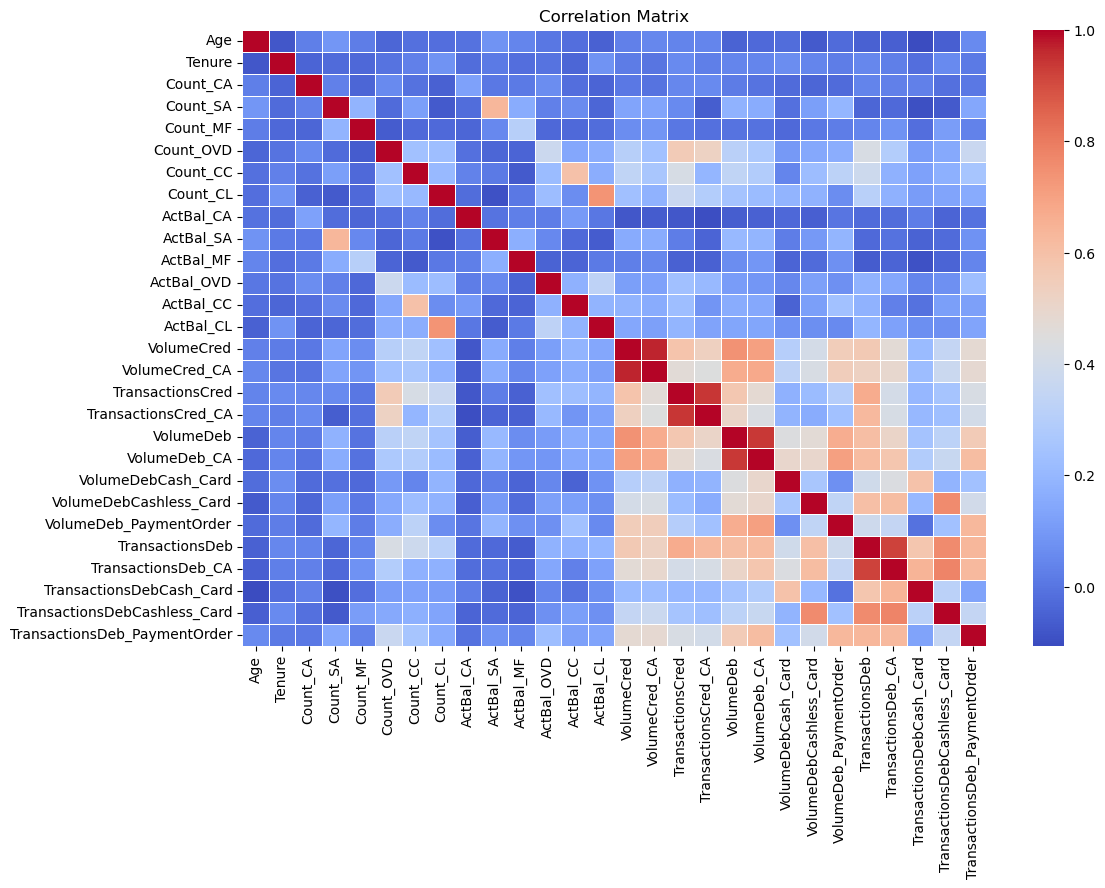

In [34]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Oversampling to handle imbalanced data

In [ ]:
# Random oversampling 
X_train_majority = X_train[y_train==0]
X_train_minority = X_train[y_train==1]

In [ ]:
df_minority_oversampled = resample(X_train_minority, 
                                   replace=True,     # Sample with replacement
                                   n_samples=X_train_majority.shape[0],  # Match majority class size
                                   random_state=50)

In [ ]:
X_train_oversampled = pd.concat([X_train_majority, df_minority_oversampled])


In [ ]:
y_train_oversampled = pd.concat([pd.Series([0]*X_train_majority.shape[0]),pd.Series([1]*df_minority_oversampled.shape[0])])

In [ ]:
print(X_train_majority.shape)
print(X_train_minority.shape)
print(df_minority_oversampled.shape)
print(X_train_oversampled.shape)
display(y_train.describe())
print(len(y_train_oversampled))
display(y_train_oversampled.describe())
y_train_oversampled.describe()['50%']

#### Using SMOTE

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=50)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# Instead of doing oversampling, we would try to modify the class weights when building the model

#Building XGBoost model

In [ ]:
X_train.shape

In [ ]:
scaling = len(y_train)/sum(y_train)
print(f"scaling = {scaling}")
param_grid = {
    'n_estimators': [100, 200,300],  # Number of boosting rounds
    'max_depth': [3, 5, 7,10],  # Maximum depth of trees
    'learning_rate': [0.005,0.01, 0.1, 0.2],  # Step size shrinkage
    'subsample': [0.8, 1.0],  # Fraction of samples used per tree
    'colsample_bytree': [0.8, 1.0],  # Fraction of features used per tree
    'scale_pos_weight' : [scaling, scaling/2,4]
}

In [ ]:
#xgb = XGBClassifier(use_label_encoder=False, eval_metric='aucpr', random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=50)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb, 
    param_grid=param_grid, 
    scoring='roc_auc',  
    cv=5,  
    verbose=1, 
    n_jobs=-1 
)

In [ ]:
start = datetime.now()
grid_search.fit(X_train, y_train)
end = datetime.now()
print(f"Total time taken for grid search : {end-start}")

with open('grid_search_MF_xgboost.pkl','wb') as f:
    pickle.dump(grid_search,f)

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

In [ ]:
# Train the model with the best parameters
best_xgb = XGBClassifier(**grid_search.best_params_, use_label_encoder=False, eval_metric='auc', random_state=50)
best_xgb.fit(X_train, y_train)
best_xgb.save_model('MF_xgboost_model.json')
'''
To load the saved model:
loaded_xgb_model = xgb.XGBClassifier()
loaded_xgb_model.load_model('xgboost_model.json')

'''

y_pred = best_xgb.predict(X_test)
# Evaluate on Test Data
accuracy = best_xgb.score(X_test, y_test)
print("Test Accuracy:", accuracy)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [ ]:
from xgboost import plot_importance
booster = best_xgb.get_booster()
f_imp = booster.get_score(importance_type="weight")
print(f_imp)
plot_importance(best_xgb)
plt.show()

# building logistic regression model

In [37]:
logreg = LogisticRegression(class_weight='balanced',random_state=50) 

In [38]:
param_grid = {
    "penalty": ["l1", "l2"],
    "solver":['liblinear','saga'],
    "C" : [0.1,2.0,5,10],
    "max_iter":[100,200,300],
}

In [39]:
grid_search = GridSearchCV(
    estimator=logreg, 
    param_grid=param_grid, 
    scoring='roc_auc',  
    cv=5,  
    verbose=1, 
    n_jobs=-1 
)

In [41]:
start = datetime.now()
grid_search.fit(X_train, y_train)
end = datetime.now()
print(f"Total time taken for grid search : {end-start}")
with open('grid_search_MF_logreg.pkl','wb') as f:
    pickle.dump(grid_search,f)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Total time taken for grid search : 0:00:18.134052


In [ ]:
cv_results = grid_search.cv_results_
print(cv_results.keys())
print(cv_results['mean_test_score'])

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

In [42]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
'''with open('MF_logreg.pkl','wb') as f:
    pickle.dump(best_model,f)'''
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.94      0.77        54
           1       0.40      0.07      0.11        30

    accuracy                           0.63        84
   macro avg       0.52      0.51      0.44        84
weighted avg       0.56      0.63      0.53        84

Confusion Matrix:
 [[51  3]
 [28  2]]


In [46]:
y_pred = best_model.predict_proba(X_test)

In [56]:
y_pred1 = y_pred.copy()
y_pred2 = y_pred.copy()

In [58]:
func = lambda a,b,c:max(a,b,c)
y_final = [func(p1[1],p2[1],p3[1]) for p1,p2,p3 in zip(y_pred,y_pred1,y_pred2)]

In [63]:
func = lambda a: 1 if a>0.5 else 0
y_pred = [func(item) for item in y_final]
y_pred = np.array(y_pred)
    
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(tabulate(df_report, headers='keys', tablefmt='pretty'))

NameError: name 'tabulate' is not defined

In [ ]:
func = lambda a: 1 if a>0.5 else 0
    y_pred = [func(item) for item in prob_ensemble]
    y_pred = np.array(y_pred)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()feature_importance = best_model.coef_[0]
for feature, importance in zip(X_train.columns,func = lambda a: 1 if a>0.5 else 0
    y_pred = [func(item) for item in prob_ensemble]
    y_pred = np.array(y_pred)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose() feature_importance):
    print(f"Feature: {feature}, Importance: {importance}")
normalized_importance = abs(feature_importance) / sum(abs(feature_importance))

In [ ]:
df_imp = pd.DataFrame(list(normalized_importance),columns=['normalized_importance'])
df_imp['Feature'] = list(X_train.columns)
df_imp

# Building svm model

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],                # Regularization parameter
    'kernel': ['linear', 'rbf'],      # Type of kernel
    'gamma': ['scale', 'auto'],       # Kernel coefficient
    'degree': [3, 4],         # Only for 'poly' kernel
}

In [ ]:
svm = SVC(class_weight='balanced',random_state=50)

In [ ]:
grid_search = GridSearchCV(
    estimator=svm, 
    param_grid=param_grid, 
    scoring='roc_auc', 
    cv=5, 
    verbose=1, 
    n_jobs=-1)

In [ ]:
start = datetime.now()
grid_search.fit(X_train, y_train)
end = datetime.now()
print(f"Total time taken for grid search : {end-start}")
with open('grid_search_MF_svm.pkl','wb') as f:
    pickle.dump(grid_search,f)

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

In [ ]:
best_model = grid_search.best_estimator_
with open('MF_svm.pkl','wb') as f:
    pickle.dump(best_model,f)
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Define pipeline

In [ ]:
# Define preprocessing steps
numeric_features = cols_to_standardize
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())  # Normalize numerical features
])

categorical_features = ["Sex"]
categorical_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))  # Convert categorical to numerical
])

# Combine preprocessing
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# Define the final pipeline
model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(eval_metric="auc"))
])
scaling = len(y_train)/sum(y_train)
print(f"scaling = {scaling}")
param_grid = {
    'n_estimators': [100, 200,300,400],  # Number of boosting rounds
    'max_depth': [3, 5, 7,10, 15,20,25],  # Maximum depth of trees
    'learning_rate': [0.005,0.01, 0.1, 0.2],  # Step size shrinkage
    'subsample': [0.8, 1.0],  # Fraction of samples used per tree
    'colsample_bytree': [0.8, 1.0],  # Fraction of features used per tree
    'scale_pos_weight' : [scaling, scaling/2]
}
grid_search = GridSearchCV(model_pipeline, param_grid, scoring="roc_auc", cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# build regression model

In [87]:
data = pd.read_pickle('data_for_modeling.pkl')
data.describe()

,Client,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
count,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.00000,736.000000,736.000000,736.000000,736.000000
mean,819.199728,42.997283,99.686141,1.070652,0.220109,0.610054,0.267663,0.110054,0.093750,1295.437777,515.665915,237.081740,44.134293,32.170374,337.759881,903.959908,812.276277,5.194293,4.047554,911.662309,815.300632,214.868742,123.392193,337.050066,15.031250,12.846467,1.987772,4.771739,4.139946,0.199728,0.21875,0.293478,1.689595,2.759137,3.386683
std,466.553208,18.351148,65.084231,0.300399,0.500805,3.723630,0.443042,0.313170,0.318438,1881.728683,1607.668206,1158.207071,194.170898,161.755186,1520.559690,996.378276,869.201186,5.557518,4.286244,995.407105,850.236635,320.619098,212.612753,529.799861,14.354514,11.635721,2.676908,7.336393,4.598519,0.400068,0.41368,0.455665,6.600352,19.812291,6.560099
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.479286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,421.750000,29.000000,43.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,72.952321,0.000000,0.000000,0.000000,0.000000,0.000000,212.147232,196.441696,2.000000,2.000000,202.868929,188.879464,0.000000,0.000000,0.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,822.500000,41.000000,93.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,461.978929,0.000000,0.000000,0.000000,0.000000,0.000000,620.089821,572.895714,3.000000,3.000000,626.870714,588.928214,71.428571,23.606607,154.437500,11.500000,10.000000,1.000000,1.000000,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,1221.500000,57.000000,151.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1746.064107,0.000000,0.000000,0.000000,0.000000,0.000000,1234.478839,1142.673214,6.000000,4.000000,1260.244107,1159.651429,321.428571,168.537768,433.258036,21.000000,18.000000,3.000000,7.000000,6.000000,0.000000,0.00000,1.000000,0.000000,0.000000,4.223214
max,1615.000000,88.000000,267.000000,3.000000,3.000000,79.000000,1.000000,1.000000,2.000000,9830.705357,9686.631071,9824.236786,2055.325357,1767.785357,17300.489643,5998.368929,5823.408929,40.000000,33.000000,5647.542857,5244.964286,2250.000000,1889.976429,4232.285714,102.000000,79.000000,25.000000,47.000000,24.000000,1.000000,1.00000,1.000000,65.704107,407.962500,46.392857


In [4]:
data['Total_revenue'] = data.Revenue_MF+data.Revenue_CC+data.Revenue_CL
data=data[data.Total_revenue>0]

In [5]:
def bin_plot_barchart(df, colname, col_min_val, col_max_val,bin_size, binned_colname):
    tmp = df.copy()
    bins = range(col_min_val, col_max_val+bin_size, bin_size)  # Create bins from 0 to 100 with a step of 10
    labels = [f'{i}-{i+bin_size-1}' for i in bins[:-1]]  # Create bin labels like '0-9', '10-19', etc.

    # Step 2: Bin the column using pd.cut()
    tmp[binned_colname] = pd.cut(tmp[colname], bins=bins, labels=labels, right=False)

    # Step 3: Count the number of values in each bin
    tmp_group_counts = (tmp[binned_colname].value_counts().sort_index() / tmp.shape[0])*100

    # Step 4: Plot a bar chart
    plt.figure(figsize=(8, 6))
    tmp_group_counts.plot(kind='bar', color='skyblue')
    plt.title(colname+' Distribution in Groups of '+str(bin_size))
    plt.xlabel(binned_colname)
    plt.ylabel('Percentage')
    plt.xticks(rotation=45)
    plt.tight_layout()  # Adjust the layout to fit everything
    plt.show()

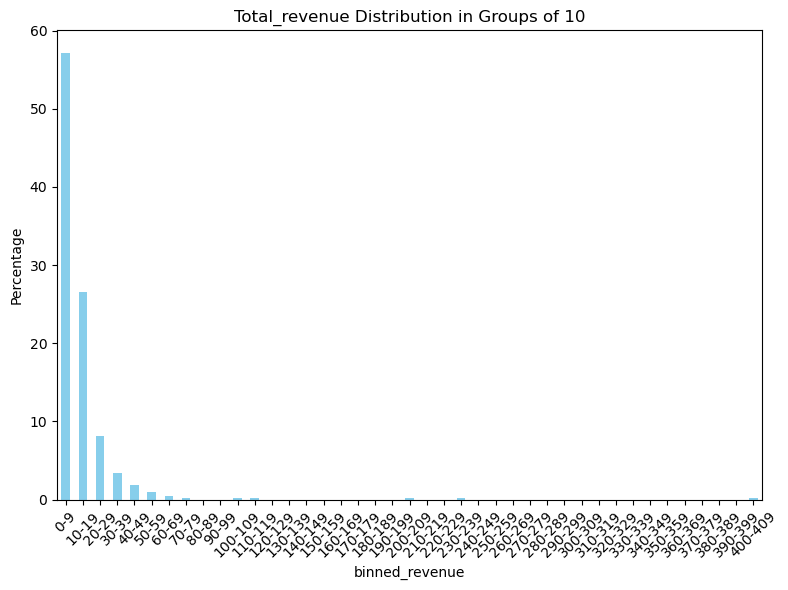

In [6]:
bin_plot_barchart(data, 'Total_revenue', 0, 410,10, 'binned_revenue')

In [7]:

data.Total_revenue.describe([0,.25,.5,.75,.85,.95,0.99,1])

count    418.000000
mean      13.796329
std       27.518151
min        0.004821
0%         0.004821
25%        3.580357
50%        8.446429
75%       15.784018
85%       20.403143
95%       37.349027
99%       97.847614
100%     407.962500
max      407.962500
Name: Total_revenue, dtype: float64

In [9]:
# Remove outliers
# Removing total revenue values where total revenue is above the 99 percentile value
data_sanitized = data[data.Total_revenue <98]

In [ ]:
print(data.shape)
print(data_sanitized.shape)

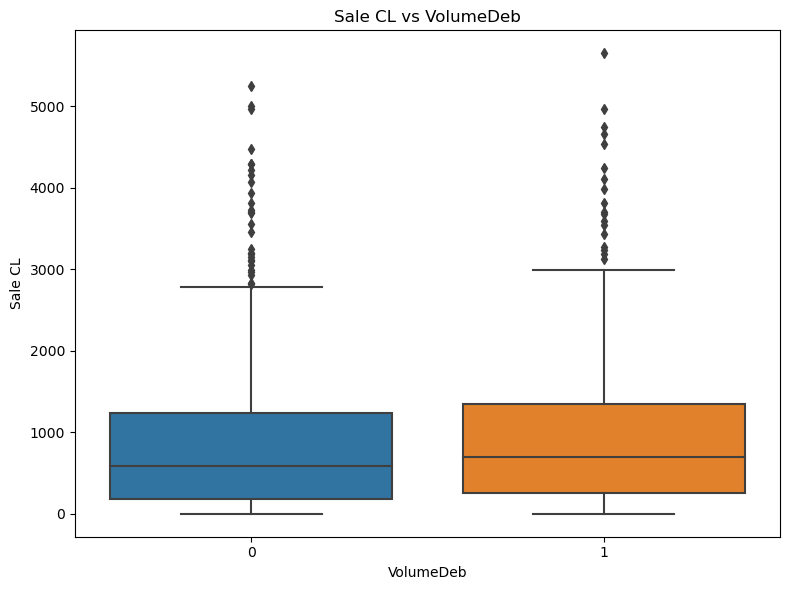

In [103]:
data_sanitized = data.copy()
n_features = data_sanitized.shape[1] -1 
n_features = 1
fig, axes = plt.subplots(n_features, 1, figsize=(8, 6*n_features))

# If only one feature, `axes` is not an array, so we need to handle that

if n_features == 1:
    axes = [axes]

for i, column in enumerate(['VolumeDeb']):  # Excluding the target column
    sns.boxplot(y=column, x='Sale_CL', data=data_sanitized,ax=axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Sale CL')
    axes[i].set_title(f'Sale CL vs {column}')
    
# Loop through each feature and plot the target against the feature
'''for i, column in enumerate(data_sanitized.columns[:-1]):  # Excluding the target column
    axes[i].scatter(data_sanitized[column], data_sanitized['Sale_MF'], color='blue')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Sale MF')
    axes[i].set_title(f'Sale MF vs {column}')'''

# Adjust the layout
plt.tight_layout()
plt.show()

In [10]:
Rev_bins = pd.cut(data.Total_revenue, bins=[10,20,30,40,50,100,400])  # Create quantile-based bins
Rev_bins = pd.qcut(data.Total_revenue, q=[0,.5,.75,.85,.95,1])  # Create quantile-based bins

Rev_bins

1      (0.0038199999999999996, 8.446]
4      (0.0038199999999999996, 8.446]
5                    (15.784, 20.403]
6                    (20.403, 37.349]
7                     (8.446, 15.784]
                    ...              
934                  (20.403, 37.349]
936                   (8.446, 15.784]
937    (0.0038199999999999996, 8.446]
945                  (15.784, 20.403]
946    (0.0038199999999999996, 8.446]
Name: Total_revenue, Length: 418, dtype: category
Categories (5, interval[float64, right]): [(0.0038199999999999996, 8.446] < (8.446, 15.784] < (15.784, 20.403] < (20.403, 37.349] < (37.349, 407.963]]

In [11]:
def prepare_data(full_data_with_labels,prep_config):
    assert full_data_with_labels.shape > (0,0) , "Error, dataset is empty"
    data_with_labels = full_data_with_labels.iloc[np.where((full_data_with_labels.Sale_MF+full_data_with_labels.Sale_CC+full_data_with_labels.Sale_CL)>0)[0],].copy()
    # Step 1 :  Encode categorical variables
    if len(prep_config["cat_cols_to_encode"]) > 0:
        assert set(prep_config["cat_cols_to_encode"]).issubset(set(data_with_labels.columns)), "Categorical columns are not in the dataset"
        data_encoded = pd.get_dummies(data_with_labels, columns=prep_config['cat_cols_to_encode'])
        print("Data with categorical variables encoded using one hot encoding")
        display(data_encoded.head())
    
    # Step 2 :  Split into training and test set
    dependent_variable = prep_config['target_variable']
    print("dependent variable :",set({dependent_variable}))
    
    ## Drop unnecessary columns
    cols_to_drop = set(['Sale_MF', 'Sale_CC', 'Sale_CL','Revenue_MF', 'Revenue_CC', 'Revenue_CL', 'Client']) - set({dependent_variable})  
    data_encoded.drop(columns=list(cols_to_drop),inplace=True)
    
    print("all columns:",data_encoded.columns)
    assert set({dependent_variable}).issubset(set(data_encoded.columns)), "Target variable provided not in the dataset"
    independent_variables = list(set(data_encoded.columns)-set({dependent_variable}))
    print("target_variable = ",dependent_variable)
    print("independent_variables = ",independent_variables)
    
    ## calculate stratification bins if data preparation for regression
    if prep_config["strat_for"] == 'regression':
        Rev_bins = pd.qcut(data_encoded.Total_revenue, q=[0,.5,.75,.85,.95,1])  # Create quantile-based bins
        stratify_based_on = Rev_bins
    else:
        stratify_based_on = data_encoded[dependent_variable]
        
    print("shape of independent variable ",data_encoded[independent_variables].shape)
    print("shape of dependent variable ", data_encoded[dependent_variable].shape)
    
    try:
        X_train, X_test, y_train, y_test = train_test_split(data_encoded[independent_variables], data_encoded[dependent_variable], test_size=prep_config['test_split_size'], random_state=50, stratify=stratify_based_on)
    except ValueError as e:
        print(f"ValueError: {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")
    
    print(f"size of training set : {X_train.shape}")
    print(f"size of training set : {X_test.shape}")
    
    # Step 3 : Data normalization
    scaler = StandardScaler()
    try:
        X_train[prep_config['numeric_cols_to_standardize']] = scaler.fit_transform(X_train[prep_config['numeric_cols_to_standardize']])
        with open('scaler.pkl','wb') as f:
            pickle.dump(scaler,f)
    except Exception as e:
        print(f"Unexpected error: {e}")
    print("X_train after normalization")
    display(X_train.head())
    print("X_train summary after normalization")
    display(X_train.describe())
    
    return X_train,X_test,y_train,y_test

In [ ]:
prep_config = {
    "numeric_cols_to_standardize":['Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder'],
    "cat_cols_to_encode":['Sex'],
    "target_variable":'Total_revenue',
    "test_split_size": 0.2,
    "strat_for":'regression' # Can take two values, 'regression'/'classification'
}
X_train,X_test,y_train,y_test = prepare_data(data_sanitized, prep_config)

In [ ]:
print(X_train.columns)
print(X_test.columns)
sum(y_train)/len(y_train)
print(len(y_test))

In [ ]:
## Ridge regression with grid search

In [15]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import math

In [ ]:
ridge = Ridge(fit_intercept=True)
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100,300,600,900,1500]}
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Alpha:", grid_search.best_params_['alpha'])

numeric_cols_to_standardize=['Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder']

with open('./'+'scaler.pkl','rb') as f:
    scaler = pickle.load(f)
x_test_scaled = X_test.copy()
x_test_scaled[numeric_cols_to_standardize] = scaler.transform(X_test[numeric_cols_to_standardize])

y_pred = grid_search.best_estimator_.predict(x_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print("Test RMSE:", math.sqrt(mse))

In [ ]:
feature_importance = grid_search.best_estimator_.coef_
df_imp = pd.DataFrame(list(abs(feature_importance)),columns=['feature_importance'])
df_imp['Feature'] = list(x_test_scaled.columns)

df_imp.sort_values(by='feature_importance',ascending=False)

## Training model using top 10 features

In [ ]:
cols_to_keep = list(df_imp.loc[np.where(df_imp.feature_importance>0.06)[0],'Feature'])
cols_to_keep.append('Total_revenue')
cols_to_keep[0:len(cols_to_keep)-1]

In [ ]:
data_red = data_sanitized[cols_to_keep]
Rev_bins = pd.qcut(data_red.Total_revenue, q=[0,.5,.75,.85,.95,1])  # Create quantile-based bins
stratify_based_on = Rev_bins
independent_variables = cols_to_keep[0:len(cols_to_keep)-1]
dependent_variable = cols_to_keep[-1]
try:
    X_train, X_test, y_train, y_test = train_test_split(data_red[independent_variables], data_red[dependent_variable], test_size=0.2, random_state=50, stratify=stratify_based_on)
except ValueError as e:
    print(f"ValueError: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")

# Step 3 : Data normalization
scaler = StandardScaler()
try:
    X_train[independent_variables] = scaler.fit_transform(X_train[independent_variables])
    with open('scaler.pkl','wb') as f:
        pickle.dump(scaler,f)
except Exception as e:
    print(f"Unexpected error: {e}")

    

In [ ]:
ridge = Ridge(fit_intercept=True)
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100,300,600,900,1500]}
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Alpha:", grid_search.best_params_['alpha'])

with open('./'+'scaler.pkl','rb') as f:
    scaler = pickle.load(f)
x_test_scaled = X_test.copy()
x_test_scaled[independent_variables] = scaler.transform(X_test[independent_variables])

y_pred = grid_search.best_estimator_.predict(x_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print("Test RMSE:", math.sqrt(mse))

In [ ]:
len(y_pred),len(y_test)
sum(y_test)/len(y_test)

In [ ]:
df = pd.DataFrame(y_pred,columns=['predicted'])
df['target'] = y_test
plt.figure(figsize=(8,5))
sns.scatterplot(data=df,x='predicted', y='target',s=100)
plt.title("scatter plot")
plt.show()

## Training model using forward feature selection

In [12]:
prep_config = {
    "numeric_cols_to_standardize":['Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder'],
    "cat_cols_to_encode":['Sex'],
    "target_variable":'Total_revenue',
    "test_split_size": 0.2,
    "strat_for":'regression' # Can take two values, 'regression'/'classification'
}
X_train,X_test,y_train,y_test = prepare_data(data_sanitized, prep_config)

Data with categorical variables encoded using one hot encoding


,Client,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Total_revenue,Sex_F,Sex_M
1,850,49,44,1,0.0,0.0,0.0,0.0,0.0,43.523214,0.0,0.000000,0.0000,0.000000,0.000000,1392.402857,1392.402857,3,3,1226.345357,1226.345357,0.000000,0.000000,121.928571,6,6,0,0,1,0,1,0,0.0,0.893929,0.000000,0.893929,1,0
4,225,14,187,1,0.0,0.0,1.0,0.0,0.0,345.686071,0.0,0.000000,618.3975,0.000000,0.000000,0.007500,0.007500,1,1,130.521429,130.521429,0.000000,111.235714,19.285714,5,5,0,4,1,0,0,1,0.0,0.000000,8.130714,8.130714,0,1
5,827,57,50,1,0.0,0.0,1.0,1.0,0.0,49.193571,0.0,0.000000,0.0000,0.464286,0.000000,1755.281786,1750.404286,9,6,1474.321429,1455.035714,607.142857,17.857143,843.250000,26,23,4,1,17,0,1,1,0.0,7.928571,12.242143,20.170714,0,1
6,1231,6,232,1,0.0,0.0,0.0,0.0,0.0,819.853929,0.0,0.000000,0.0000,0.000000,0.000000,0.015714,0.015714,2,2,2257.000000,2257.000000,2250.000000,0.000000,0.000000,9,9,6,0,0,0,0,1,0.0,0.000000,24.434643,24.434643,1,0
7,739,69,55,1,1.0,8.0,1.0,0.0,1.0,5519.308929,0.0,9824.236786,0.0000,0.000000,3868.679643,208.446786,150.003571,4,2,287.003571,282.575000,0.000000,211.182143,0.000000,7,5,0,3,0,0,1,1,0.0,2.138571,7.785714,9.924286,0,1


dependent variable : {'Total_revenue'}
all columns: Index(['Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD',
       'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF',
       'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred', 'VolumeCred_CA',
       'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA',
       'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'Total_revenue', 'Sex_F', 'Sex_M'],
      dtype='object')
target_variable =  Total_revenue
independent_variables =  ['VolumeDebCash_Card', 'VolumeCred', 'Tenure', 'Count_MF', 'Sex_F', 'TransactionsCred', 'TransactionsDeb_PaymentOrder', 'ActBal_MF', 'TransactionsDebCashless_Card', 'VolumeDeb_PaymentOrder', 'VolumeCred_CA', 'TransactionsDeb', 'VolumeDebCashless_Card', 'Count_OVD', 'Count_SA', 'Age', 'Transaction

,VolumeDebCash_Card,VolumeCred,Tenure,Count_MF,Sex_F,TransactionsCred,TransactionsDeb_PaymentOrder,ActBal_MF,TransactionsDebCashless_Card,VolumeDeb_PaymentOrder,VolumeCred_CA,TransactionsDeb,VolumeDebCashless_Card,Count_OVD,Count_SA,Age,TransactionsCred_CA,Count_CL,VolumeDeb,VolumeDeb_CA,Count_CC,ActBal_CA,Sex_M,ActBal_CL,ActBal_CC,Count_CA,ActBal_OVD,TransactionsDebCash_Card,ActBal_SA,TransactionsDeb_CA
830,-0.669980,-0.868481,-0.279760,0.209659,1,-0.566048,-0.901270,0.201251,-0.676363,-0.700439,-0.899301,-0.946779,-0.623767,-0.589015,1.569863,-1.226484,-0.698441,-0.286299,-0.893447,-0.970638,-0.327693,0.935922,0,-0.221113,-0.190496,-0.264413,-0.221782,-0.722331,0.695276,-1.018349
915,-0.669980,2.399617,1.617956,0.018004,1,0.403480,0.865139,2.676762,-0.676363,2.035406,2.820130,-0.502255,-0.623767,-0.589015,1.569863,-0.048514,0.344480,-0.286299,0.287362,0.478487,-0.327693,0.442772,0,-0.221113,-0.190496,-0.264413,-0.221782,-0.722331,1.500039,-0.449315
525,-0.574333,-0.752691,-0.620756,-0.173651,0,-0.566048,-0.901270,-0.216118,1.527120,-0.700439,-0.764821,0.132780,0.612190,-0.589015,-0.461724,-0.048514,-0.489857,-0.286299,-0.619260,-0.634148,-0.327693,-0.617137,1,-0.221113,-0.190496,-0.264413,-0.221782,-0.405350,-0.345159,0.363591
694,-0.669980,0.152634,0.950790,-0.173651,0,1.534597,1.085940,-0.216118,2.564054,-0.110939,0.125410,2.228394,0.830478,1.697749,-0.461724,0.647559,1.804569,-0.286299,0.340048,0.236190,-0.327693,-0.666052,1,-0.221113,-0.190496,-0.264413,0.098492,-0.722331,-0.345159,2.151984
598,-0.563706,-0.789057,0.624620,-0.173651,1,0.241892,-0.680469,-0.216118,-0.287513,-0.692371,-0.808506,-0.184737,-0.450492,1.697749,-0.461724,-0.316235,0.344480,-0.286299,-0.735906,-0.879482,-0.327693,-0.666052,0,-0.221113,-0.190496,-0.264413,-0.221782,-0.405350,-0.345159,-0.530606


X_train summary after normalization


,VolumeDebCash_Card,VolumeCred,Tenure,Count_MF,Sex_F,TransactionsCred,TransactionsDeb_PaymentOrder,ActBal_MF,TransactionsDebCashless_Card,VolumeDeb_PaymentOrder,VolumeCred_CA,TransactionsDeb,VolumeDebCashless_Card,Count_OVD,Count_SA,Age,TransactionsCred_CA,Count_CL,VolumeDeb,VolumeDeb_CA,Count_CC,ActBal_CA,Sex_M,ActBal_CL,ActBal_CC,Count_CA,ActBal_OVD,TransactionsDebCash_Card,ActBal_SA,TransactionsDeb_CA
count,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,330.000000,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,330.000000,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,330.000000,330.000000,330.000000,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02
mean,3.229740e-17,7.536059e-17,-9.689219e-17,4.306320e-17,0.490909,9.420074e-18,-4.575465e-17,2.691450e-17,2.254089e-17,1.184238e-16,3.768030e-17,7.805204e-17,-4.306320e-17,-2.691450e-17,2.422305e-17,-4.037175e-18,-3.229740e-17,0.000000,-5.382900e-17,5.382900e-17,6.728624e-17,-1.111905e-16,0.509091,0.000000,0.000000,-2.153160e-17,2.691450e-18,-2.422305e-17,-4.710037e-17,-1.614870e-17
std,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,0.500677,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,0.500677,1.001519,1.001519,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00
min,-6.699801e-01,-8.705104e-01,-1.599266e+00,-1.736510e-01,0.000000,-8.892240e-01,-9.012703e-01,-2.161181e-01,-6.763634e-01,-7.004394e-01,-8.993051e-01,-1.010282e+00,-6.237667e-01,-5.890151e-01,-4.617243e-01,-2.190278e+00,-9.070251e-01,-0.286299,-8.953846e-01,-9.730167e-01,-3.276928e-01,-6.660522e-01,0.000000,-0.221113,-0.190496,-2.644133e-01,-2.217824e-01,-7.223307e-01,-3.451586e-01,-1.099640e+00
25%,-6.699801e-01,-6.728765e-01,-8.431449e-01,-1.736510e-01,0.000000,-5.660479e-01,-9.012703e-01,-2.161181e-01,-6.763634e-01,-7.004394e-01,-6.872909e-01,-7.562684e-01,-6.237667e-01,-5.890151e-01,-4.617243e-01,-7.981316e-01,-4.898568e-01,-0.286299,-6.967491e-01,-7.439665e-01,-3.276928e-01,-6.367895e-01,0.000000,-0.221113,-0.190496,-2.644133e-01,-2.217824e-01,-7.223307e-01,-3.451586e-01,-7.744776e-01
50%,-4.478729e-01,-3.420203e-01,-7.219768e-02,-1.736510e-01,0.000000,-4.044598e-01,-2.388667e-01,-2.161181e-01,-5.467467e-01,-3.857213e-01,-3.066610e-01,-3.117442e-01,-5.158021e-01,-5.890151e-01,-4.617243e-01,-7.528625e-02,-2.812726e-01,-0.286299,-3.156385e-01,-2.790083e-01,-3.276928e-01,-4.038761e-01,1.000000,-0.221113,-0.190496,-2.644133e-01,-2.217824e-01,-4.053505e-01,-3.451586e-01,-2.460888e-01
75%,3.024312e-01,2.910940e-01,7.654661e-01,-1.736510e-01,1.000000,8.030437e-02,4.235368e-01,-2.161181e-01,3.605700e-01,2.514985e-01,3.520727e-01,4.502972e-01,2.158567e-01,1.697749e+00,-4.617243e-01,7.546473e-01,1.358957e-01,-0.286299,2.702334e-01,3.537184e-01,-3.276928e-01,1.705734e-01,1.000000,-0.221113,-0.190496,-2.644133e-01,-2.217824e-01,2.286100e-01,-3.451586e-01,5.261718e-01
max,6.025311e+00,4.783244e+00,2.359251e+00,1.496709e+01,1.000000,5.574298e+00,3.735555e+00,7.062094e+00,4.249071e+00,6.394009e+00,5.237677e+00,5.467070e+00,4.964695e+00,1.697749e+00,5.633036e+00,2.360970e+00,5.976253e+00,6.012283,4.002855e+00,4.776436e+00,3.051639e+00,4.966843e+00,1.000000,9.094671,10.654293,5.753268e+00,1.027648e+01,7.202175e+00,5.412055e+00,5.322317e+00


In [13]:
from sklearn.feature_selection import SequentialFeatureSelector

In [16]:
ridge = Ridge(fit_intercept=True)
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100,300,600]}
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
sfs = SequentialFeatureSelector(grid_search, n_features_to_select=5, direction='forward', cv=5)
sfs.fit(X_train, y_train)
selected_features = sfs.get_support(indices=True)
print("Selected feature indices:", selected_features)


Selected feature indices: [ 3  7  8  9 10]


In [18]:
X_train_selected = X_train.iloc[:, selected_features]

best_model = grid_search.fit(X_train_selected, y_train)

In [22]:
with open('./'+'scaler.pkl','rb') as f:
    scaler = pickle.load(f)
x_test_scaled = X_test.copy()
x_test_scaled[prep_config["numeric_cols_to_standardize"]] = scaler.transform(X_test[prep_config["numeric_cols_to_standardize"]])
X_test_selected = x_test_scaled.iloc[:, selected_features]
test_score = best_model.score(X_test_selected, y_test)
print("Test Score (R²):", test_score)

y_pred = best_model.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
print("Test RMSE:", math.sqrt(mse))

Test Score (R²): -10.080390459397837
Test RMSE: 10.080390459397837


In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor()

# Step 3: Set up a parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.3],  # Learning rate
    'max_depth': [3, 5, 7],  # Depth of the trees
    'subsample': [0.7, 0.8, 1.0],  # Fraction of samples used for fitting trees
    'colsample_bytree': [0.7, 0.8, 1.0]  # Fraction of features to be used for each tree
}

# Step 4: Set up the GridSearchCV with XGBRegressor and the parameter grid
grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           scoring='neg_root_mean_squared_error',  # We want to minimize MSE
                           cv=5,  # Cross-validation with 5 folds
                           verbose=1)  # Print progress

# Step 5: Fit the grid search on training data
grid_search.fit(X_train, y_train)

# Step 6: Get the best parameters and best score
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Negative MSE Score: {grid_search.best_score_}")

# Step 7: Make predictions with the best model
best_model = grid_search.best_estimator_

x_test_scaled = X_test.copy()
x_test_scaled[numeric_cols_to_standardize] = scaler.transform(X_test[numeric_cols_to_standardize])

y_pred = best_model.predict(x_test_scaled)

# Step 8: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error on Test Data: {math.sqrt(mse)}")


In [ ]:
df = pd.DataFrame(y_pred,columns=['predicted'])
df['target'] = y_test
plt.figure(figsize=(8,5))
sns.scatterplot(data=df,x='predicted', y='target',s=100)
plt.title("scatter plot")
plt.show()

In [ ]:
from sklearn.svm import SVR

In [ ]:
svr_model = SVR()

# Step 3: Define the parameter grid for tuning
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Type of kernel
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.1, 1],  # Kernel coefficient
    'epsilon': [0.01, 0.1, 0.5],  # Epsilon in the loss function
    'degree': [2, 3, 4],  # Degree of the polynomial kernel function (if 'poly' kernel)
}

# Step 4: Set up the GridSearchCV with SVR
grid_search = GridSearchCV(estimator=svr_model,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',  # Use negative MSE as scoring for regression
                           cv=5,  # 5-fold cross-validation
                           verbose=1)  # Print progress during grid search

# Step 5: Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Step 6: Get the best parameters and best score
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Negative MSE Score: {grid_search.best_score_}")

# Step 7: Make predictions using the best model
best_model = grid_search.best_estimator_

x_test_scaled = X_test.copy()
x_test_scaled[numeric_cols_to_standardize] = scaler.transform(X_test[numeric_cols_to_standardize])
y_pred = best_model.predict(x_test_scaled)

# Step 8: Evaluate the model with mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Data: {math.sqrt(mse)}")

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [ ]:
pipeline = Pipeline([
    ('polynomial_features', PolynomialFeatures()),
    ('regressor', LinearRegression())
])

# Define the parameters grid for GridSearchCV
param_grid = {
    'polynomial_features__degree': [2, 3, 4, 5],  # Trying different polynomial degrees
    'regressor__fit_intercept': [True, False]  # Experimenting with fitting the intercept
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model using grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

# Predict using the best model
best_model = grid_search.best_estimator_
x_test_scaled = X_test.copy()
x_test_scaled[numeric_cols_to_standardize] = scaler.transform(X_test[numeric_cols_to_standardize])
y_pred = best_model.predict(x_test_scaled)


# Calculate the mean squared error on the test set
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Data: {math.sqrt(mse)}")

# delete

In [68]:
import xgboost as xgb
from xgboost import plot_importance

In [66]:
folder_path_target = './models/Classification/Sale_MF/'
file_toopen = 'Sale_MF_xgboost_model.json'
loaded_xgb_model = xgb.XGBClassifier()
loaded_xgb_model.load_model(folder_path_target+file_toopen)

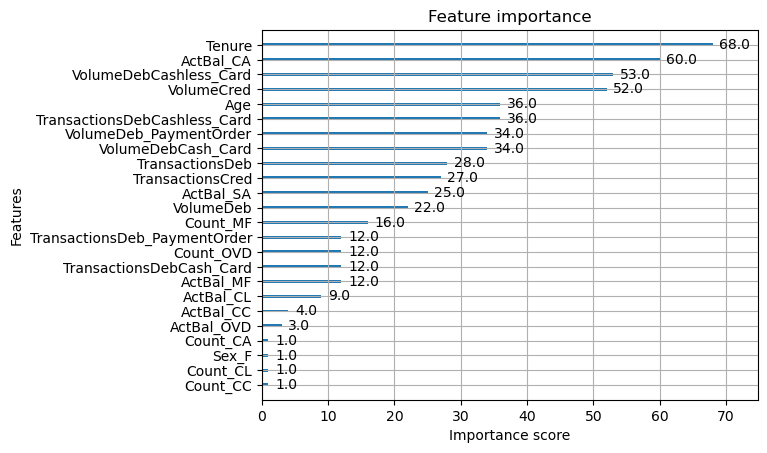

In [70]:
booster = loaded_xgb_model.get_booster()
f_imp = booster.get_score(importance_type="weight")
importance_df = pd.DataFrame(f_imp.items(), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plot_importance(loaded_xgb_model)
plt.show()

In [74]:
list(importance_df.Feature[0:5])

['Tenure', 'ActBal_CA', 'VolumeDebCashless_Card', 'VolumeCred', 'Age']